#### This program computes the linear regression coefficients and intercept to predict the 106VE04 Ni from the following features:
1. MS flow
2. recycle gas flow
3. feed solution temp
4. H2S flow
5. 106VE02 Ni concentration.
Ridge regression is used.

In [2]:
#exc1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from dateutil.parser import parse
from itertools import compress
from collections import OrderedDict
from datetime import date
import datetime
from datetime import timedelta
import re

import openpyxl
import random

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10

In [3]:
#-------Edit: Include the NaSH flow, VE02 lab results for Ni in solution, 106TK01 Ni in solution, pH, Fe

In [4]:
df_Pi = pd.read_excel(r'C:\Users\v.t.flores\Documents\MS Flow.xlsx', sheet_name='PiData_MS FLOW', index_col=False)
#Drop the row[1]
df_Pi = df_Pi.drop(df_Pi.index[0])
#Step2: Parse the DATETIME column
df_Pi['DATETIME'] = df_Pi['DATETIME'].apply(lambda x: parse(str(x)))
df_Pi.set_index('DATETIME', inplace=True)
df_comb = df_Pi
for i in df_comb.columns:
    df_comb[i] = pd.to_numeric(df_comb[i], errors='coerce')



In [7]:
df_comb['MS_Flow'] = np.where(df_comb['MS_FLOW_A']>df_comb['MS_FLOW_B'], df_comb['MS_FLOW_A'], df_comb['MS_FLOW_B'])
df_comb_Pi = df_comb[['MS_Flow', 'MS_Feed_T', 'Rec_Gas', 'H2S_Flow', 'NaSH_Flow']]

In [9]:
#used in the analysis results data. cleans up the sampling time entry
def time_cleaner(x):
    time_regex = re.compile(r'[0-8a-zA-Z:]', re.IGNORECASE| re.VERBOSE|re.DOTALL)
    timeact = time_regex.findall(x)
    newtime = ''.join(timeact)
    t = parse(x)
    new_str_time = str(t.hour)+':'+str(t.minute)+':'+str(t.second)
    return new_str_time

def generate_df_from_analysis(workbookTab, col_sampleDate, col_sampleTime, col_analysis, col_title):
    #get the start and end sample dates
    Smpl_day_index = list()
    Chem_Element_datelist = list()
    Chem_Element_list = list()
    Smpl_day_index = list()
    Chem_Element_datelist = list()
    Chem_Element_list = list()
    plus_oneday_list = ['0:0:0', '1:0:0', '2:0:0', '3:0:0', '4:0:0', '5:0:0']
    #gets the date day from the B column of the analysis file if there is value in the cell
    for i in range(1, workbookTab.max_row):
        if type(workbookTab[str(col_sampleDate) + str(i)].value) == int or type(workbookTab[str(col_sampleDate) + str(i)].value) == float:
            Smpl_day_index.append(i)
    #get the ending row that has date day
    for j in range(1, workbookTab.max_row):
        if type(workbookTab[str(col_sampleTime) + str(j)].value) == datetime.datetime:
            smpl_end_index = j
    for y in range(0, len(Smpl_day_index)):
        if Smpl_day_index[y] != Smpl_day_index[-1]:      
            for x in range(Smpl_day_index[y], Smpl_day_index[y+1]):
                if workbookTab[str(col_analysis)+str(x)].value is None: 
                    pass
                else:
                    if time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value)) in plus_oneday_list:
                        date = str((currentmonthyr)+datetime.timedelta(workbookTab[str(col_sampleDate)+str(Smpl_day_index[y])].value))\
                        +' '+time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value))
                        Chem_Element_datelist.append(parse(date))  
                        chem_element = workbookTab[str(col_analysis)+str(x)].value
                        Chem_Element_list.append(chem_element)
                    else:
                        date = str((currentmonthyr)-datetime.timedelta(1)+datetime.timedelta(workbookTab[str(col_sampleDate)+str(Smpl_day_index[y])].value))\
                        +' '+time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value))
                        Chem_Element_datelist.append(parse(date))  
                        chem_element = workbookTab[str(col_analysis)+str(x)].value
                        Chem_Element_list.append(chem_element)

        if Smpl_day_index[y] == Smpl_day_index[-1]:
            for x in range(Smpl_day_index[y], smpl_end_index+1):
                if workbookTab[str(col_analysis)+str(x)].value is None:   
                    pass
                else:
                    if time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value)) in plus_oneday_list:
                        date = str((currentmonthyr)+datetime.timedelta(workbookTab[str(col_sampleDate)+str(Smpl_day_index[y])].value))\
                        +' '+time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value))
                        Chem_Element_datelist.append(parse(date))
                        chem_element = workbookTab[str(col_analysis)+str(x)].value
                        Chem_Element_list.append(chem_element)
                    else:
                        date = str((currentmonthyr)-datetime.timedelta(1)+datetime.timedelta(workbookTab[str(col_sampleDate)+str(Smpl_day_index[y])].value))\
                        +' '+time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value))
                        Chem_Element_datelist.append(parse(date))
                        chem_element = workbookTab[str(col_analysis)+str(x)].value
                        Chem_Element_list.append(chem_element)

    Chem_Element_list_pair = list(zip(Chem_Element_list, Chem_Element_datelist[0:]))
    Chem_Element_df = pd.DataFrame(Chem_Element_list_pair)
    Chem_Element_df.columns = [col_title, 'DATETIME'] ##check if list title is updated
    Chem_Element_df.set_index('DATETIME', inplace=True)

    return Chem_Element_df

def generate_add_trace(figname, df_elemental, axis_bool):
    colname = df_elemental.columns[0]
    figname.add_trace(go.Scatter(x=df_elemental.index, y=df_elemental[colname], name=colname), secondary_y=axis_bool,)
#--------------------------------------- 

In [12]:
#---------------------
#
def time_cleaner(x):
    time_regex = re.compile(r'[0-8a-zA-Z:]', re.IGNORECASE| re.VERBOSE|re.DOTALL)
    timeact = time_regex.findall(x)
    newtime = ''.join(timeact)
    t = parse(x)
    new_str_time = str(t.hour)+':'+str(t.minute)+':'+str(t.second)
    return new_str_time
#
#
#generate_df_from_analysis: this function creates dataframe by getting laboratory results by taking the excel values from
#    every row in a specified analysis column. An example of analysis column is the column for Zn AAS analysis for NTRL.
#    The critical part of this code is in making sure that the dates and time from the laboratory analysis excel file are
#    parsed and converted into the correct datetime format.
def generate_df_from_analysis(workbookTab, col_sampleDate, col_sampleTime, col_analysis, col_title):
    #get the start and end sample dates
    Smpl_day_index = list()
    Chem_Element_datelist = list()
    Chem_Element_list = list()
    Smpl_day_index = list()
    Chem_Element_datelist = list()
    Chem_Element_list = list()
    plus_oneday_list = ['0:0:0', '1:0:0', '2:0:0', '3:0:0', '4:0:0', '5:0:0']
    #gets the date day from the B column of the analysis file if there is value in the cell
    for i in range(1, workbookTab.max_row):
        if type(workbookTab[str(col_sampleDate) + str(i)].value) == int or type(workbookTab[str(col_sampleDate) + str(i)].value) == float:
            Smpl_day_index.append(i)
    #get the ending row that has date day
    for j in range(1, workbookTab.max_row):
        if type(workbookTab[str(col_sampleTime) + str(j)].value) == datetime.datetime:
            smpl_end_index = j
    for y in range(0, len(Smpl_day_index)):
        if Smpl_day_index[y] != Smpl_day_index[-1]:      
            for x in range(Smpl_day_index[y], Smpl_day_index[y+1]):
                if workbookTab[str(col_analysis)+str(x)].value is None: 
                    pass
                else:
                    if time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value)) in plus_oneday_list:
                        date = str((currentmonthyr)+datetime.timedelta(workbookTab[str(col_sampleDate)+str(Smpl_day_index[y])].value))\
                        +' '+time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value))
                        Chem_Element_datelist.append(parse(date))  
                        chem_element = workbookTab[str(col_analysis)+str(x)].value
                        Chem_Element_list.append(chem_element)
                    else:
                        date = str((currentmonthyr)-datetime.timedelta(1)+datetime.timedelta(workbookTab[str(col_sampleDate)+str(Smpl_day_index[y])].value))\
                        +' '+time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value))
                        Chem_Element_datelist.append(parse(date))  
                        chem_element = workbookTab[str(col_analysis)+str(x)].value
                        Chem_Element_list.append(chem_element)

        if Smpl_day_index[y] == Smpl_day_index[-1]:
            for x in range(Smpl_day_index[y], smpl_end_index+1):
                if workbookTab[str(col_analysis)+str(x)].value is None:   
                    pass
                else:
                    if time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value)) in plus_oneday_list:
                        date = str((currentmonthyr)+datetime.timedelta(workbookTab[str(col_sampleDate)+str(Smpl_day_index[y])].value))\
                        +' '+time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value))
                        Chem_Element_datelist.append(parse(date))
                        chem_element = workbookTab[str(col_analysis)+str(x)].value
                        Chem_Element_list.append(chem_element)
                    else:
                        date = str((currentmonthyr)-datetime.timedelta(1)+datetime.timedelta(workbookTab[str(col_sampleDate)+str(Smpl_day_index[y])].value))\
                        +' '+time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value))
                        Chem_Element_datelist.append(parse(date))
                        chem_element = workbookTab[str(col_analysis)+str(x)].value
                        Chem_Element_list.append(chem_element)

    Chem_Element_list_pair = list(zip(Chem_Element_list, Chem_Element_datelist[0:]))
    Chem_Element_df = pd.DataFrame(Chem_Element_list_pair)
    Chem_Element_df.columns = [col_title, 'DATETIME'] ##check if list title is updated
    Chem_Element_df.set_index('DATETIME', inplace=True)

    return Chem_Element_df
#-----------------------------------------------------End----------------------------------------------------------------
#
#
#------------------------------------------------------------------------------------------------------------------------
#
def generate_add_trace(figname, df_elemental, axis_bool):
    colname = df_elemental.columns[0]
    figname.add_trace(go.Scatter(x=df_elemental.index, y=df_elemental[colname], name=colname), secondary_y=axis_bool,)
#
#----------------------------------------------------End-----------------------------------------------------------------
#
#
class LabResults():
    def __init__(self, monthyear, filePath):
        #____monthyear format examle is datetime.date(2020,7,1)
        #____filepath example is '\\thgobna001\userdata\THPAL\...\ANALYSIS RESULTS 2020\7) July _2020.xlsx'
        #____add r' at the start of the filepath to apply the regex that allows the use of the filepath as raw
        #____sef.workbook is the uploaded excel workbook of the entire analysis files so it takes time to load
        #____Create an instance of the workbook by giving it a varible name with the sample format: Jan_2020
        
        import openpyxl
        import io
        with open(filePath, "rb") as f:                  #This line of code is not really necessary but some say this can lessen the memory usage
            in_mem_file = io.BytesIO(f.read())           # so is this...
        
        self.workbook = openpyxl.load_workbook(in_mem_file, data_only=True)
        self.monthyear = monthyear   
        
    def generate_df_from_analysis(self, tabname, list_lab_index):
        #____tabname is a string type name of the tab in the laboratory analysis excel file.
        #____-------Example tabnames: '104PU01', '105TK03', '106TK01'
        #____-------Inside these tabs are the specific analysis results done on the sample taken from the 'tabname' area .
        #____list_lab_index is a list with the sample format is: ['B', 'C', 'E', '104_Pb']
        #____-------the first letter 'B' is the column letter where the day of the month is written as integers 1,2,3..30
        #____-------the second letter 'C' is the column letter where the sampling time is written; e.g. '7:00:00 AM'
        #____-------the third letter 'E' is the column where the results of the specific analysis are listed
        #____-------the last item in the list is the string you'll use as the new title; e.g. '104_Pb'
        
        workbookTab = self.workbook[tabname]
        self.list_lab_index = list_lab_index
        col_sampleDate = self.list_lab_index[0]
        col_sampleTime = self.list_lab_index[1]
        col_analysis = self.list_lab_index[2]
        col_title = self.list_lab_index[3]
        currentmonthyr = self.monthyear
        
        #get the start and end sample dates
        Smpl_day_index = list()
        Chem_Element_datelist = list()
        Chem_Element_list = list()
        Smpl_day_index = list()
        Chem_Element_datelist = list()
        Chem_Element_list = list()
        plus_oneday_list = ['0:0:0', '1:0:0', '2:0:0', '3:0:0', '4:0:0', '5:0:0']
        #gets the date day from the B column of the analysis file if there is value in the cell
        for i in range(1, workbookTab.max_row):
            if type(workbookTab[str(col_sampleDate) + str(i)].value) == int or type(workbookTab[str(col_sampleDate) + str(i)].value) == float:
                Smpl_day_index.append(i)
        #get the ending row that has date day
        for j in range(1, workbookTab.max_row):
            if type(workbookTab[str(col_sampleTime) + str(j)].value) == datetime.datetime:
                smpl_end_index = j
        for y in range(0, len(Smpl_day_index)):
            if Smpl_day_index[y] != Smpl_day_index[-1]:      
                for x in range(Smpl_day_index[y], Smpl_day_index[y+1]):
                    if workbookTab[str(col_analysis)+str(x)].value is None: 
                        pass
                    else:
                        if time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value)) in plus_oneday_list:
                            date = str((currentmonthyr)+datetime.timedelta(workbookTab[str(col_sampleDate)+str(Smpl_day_index[y])].value))\
                            +' '+time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value))
                            Chem_Element_datelist.append(parse(date))  
                            chem_element = workbookTab[str(col_analysis)+str(x)].value
                            Chem_Element_list.append(chem_element)
                        else:
                            date = str((currentmonthyr)-datetime.timedelta(1)+datetime.timedelta(workbookTab[str(col_sampleDate)+str(Smpl_day_index[y])].value))\
                            +' '+time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value))
                            Chem_Element_datelist.append(parse(date))  
                            chem_element = workbookTab[str(col_analysis)+str(x)].value
                            Chem_Element_list.append(chem_element)

            if Smpl_day_index[y] == Smpl_day_index[-1]:
                for x in range(Smpl_day_index[y], smpl_end_index+1):
                    if workbookTab[str(col_analysis)+str(x)].value is None:   
                        pass
                    else:
                        if time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value)) in plus_oneday_list:
                            date = str((currentmonthyr)+datetime.timedelta(workbookTab[str(col_sampleDate)+str(Smpl_day_index[y])].value))\
                            +' '+time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value))
                            Chem_Element_datelist.append(parse(date))
                            chem_element = workbookTab[str(col_analysis)+str(x)].value
                            Chem_Element_list.append(chem_element)
                        else:
                            date = str((currentmonthyr)-datetime.timedelta(1)+datetime.timedelta(workbookTab[str(col_sampleDate)+str(Smpl_day_index[y])].value))\
                            +' '+time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value))
                            Chem_Element_datelist.append(parse(date))
                            chem_element = workbookTab[str(col_analysis)+str(x)].value
                            Chem_Element_list.append(chem_element)

        Chem_Element_list_pair = list(zip(Chem_Element_list, Chem_Element_datelist[0:]))
        Chem_Element_df = pd.DataFrame(Chem_Element_list_pair)
        Chem_Element_df.columns = [col_title, 'DATETIME']#------------------------------------------------check if list title is updated
        Chem_Element_df.set_index('DATETIME', inplace=True)

        return Chem_Element_df
#---------------------------------------------------------------End---------------------------------------------------------------------
#
#
def join_DF(dfsList1):
    df = dfsList1[0]
    for i in range(1,len(dfsList1)):
        df = df.join(dfsList1[i], how='outer')
    return df
#
#---------------------------------------------------------------End---------------------------------------------------------------------
#
#
def append_monthsDF(dfsListmonthly): #takes the list of dataframes from monthly lab results of one sampling area
    df = dfsListmonthly[0]
    for i in range(1,len(dfsListmonthly)):
        df = df.append(dfsListmonthly[i])
    try:
        df.set_index('DATETIME', inplace=True)
    except:
        pass
    return df  
#
#
#---------------------------------------------------------------End----------------------------------------------------------------------
#
#
# Prepare the following lists: sample_area, analysis_type
def generate_combined_df_by_month(month_WB, sample_area, analysis_type):
    df_List = []
    for i in analysis_type:
        df_analysis = month_WB.generate_df_from_analysis(sample_area, i)
        df_List.append(df_analysis)
    for i in df_List:
        df = join_DF(df_List)
    return df

#
#
#---------------------------------------------------------------End----------------------------------------------------------------------
#
#  make_df_for_each_FT01_by_month_then_export_excel: This function exports the 
def make_df_for_each_FT01_by_month_then_export_excel(monthNumber, analysis_type_FT01AtoF_list):
    month_ = LabResults(currentmonthyr_list[monthNumber-1], filepath_list[monthNumber-1])
    letters = 'ABCDEF'
    FT01_months_df = []
    for i in range(0,6):
        FT01_ = generate_combined_df_by_month(month_, '105FT01', analysis_type_FT01AtoF_list[i])
        FT01_.to_excel(r'C:\Users\v.t.flores\Documents\FT01{}_2020_0{}.xlsx'.format(letters[i], monthNumber))
#
#
#---------------------------------------------------------------End----------------------------------------------------------------------
#
# generate_add_trace: this function is for creating plots using plotly express
def generate_add_trace(figname, df_elemental, axis_bool):
    colname = df_elemental.columns[0]
    figname.add_trace(go.Scatter(x=df_elemental.index, y=df_elemental[colname], name=colname), secondary_y=axis_bool,)   
#
#
#--------------------------------------------------------------End-----------------------------------------------------------------------
#
#
def generate_plot_from_df(figname, df,df_axis_truefalse_list):
    for i in range(0, len(df.columns)):
        colname = df.columns[i]
        figname.add_trace(go.Scatter(x=df[colname].index, y=df[colname], name=colname), secondary_y=df_axis_truefalse_list[i],)
#
#
#--------------------------------------------------------------End-----------------------------------------------------------------------

def make_a_graph(Samplesource_name, figname, df, axisTrueFalse):
    generate_plot_from_df(figname, df, axisTrueFalse)
    print(Samplesource_name)
    print(df.columns)

    t = datetime.datetime.now()
    title_plot = Samplesource_name+"<b>Laboratory Analysis Results</b>" + '<br>' + 'Updated as of:' + str(t.strftime("%m/%d/%Y %H:%M:%S"))+'H'
    
    figname.update_layout(title_text=title_plot)                                 # Add figure title
    
    figname.update_xaxes(title_text="DateTime")                                  # Set x-axis title
    
    figname.update_yaxes(title_text= "<b> </b>", secondary_y=False)              # Set y-axes titles primary
    figname.update_yaxes(title_text="<b> </b>", secondary_y=True)                # Set y-axes titles secondary
    
    #this function needs upgrade to correctly label the axis
    return figname
#
#
#--------------------------------------------------------------End-----------------------------------------------------------------------
#
def replace_0_with_nan(df, dfcol_list): # the argument df is the dataframe, dfcol_list is the list of column names we want to clean up
    for i in dfcol_list:
        df[i] = np.where(df[i] == 0, np.nan, df[i])
#       
#--------------------------------------------------------------End-----------------------------------------------------------------------        
#
#
def convert_to_numeric(df):
    for i in df.columns:
        try:
            df[i] = pd.to_numeric(df[i], errors='coerce')
        except:
            print(i, " has error.")
#            
#--------------------------------------------------------------End-----------------------------------------------------------------------            

In [13]:
analysis_Address_01 = r'\\thgobna001\userdata\THPAL\Department\TAGANITO\SHARED\AnalysisResult\ANALYSIS RESULTS 2020\JANUARY 2020\1) JANUARY_2020.xlsx'
analysis_Address_02 = r'\\thgobna001\userdata\THPAL\Department\TAGANITO\SHARED\AnalysisResult\ANALYSIS RESULTS 2020\FEBRUARY 2020\2) FEBRUARY _2020.xlsx'
analysis_Address_03 = r'\\thgobna001\userdata\THPAL\Department\TAGANITO\SHARED\AnalysisResult\ANALYSIS RESULTS 2020\MARCH 2020\3) March _2020.xlsx'
analysis_Address_04 = r'\\thgobna001\userdata\THPAL\Department\TAGANITO\SHARED\AnalysisResult\ANALYSIS RESULTS 2020\APRIL 2020\4) April _2020.xlsx'
analysis_Address_05 = r'\\thgobna001\userdata\THPAL\Department\TAGANITO\SHARED\AnalysisResult\ANALYSIS RESULTS 2020\MAY 2020\5) MAY_2020.xlsx'
analysis_Address_06 = r'\\thgobna001\userdata\THPAL\Department\TAGANITO\SHARED\AnalysisResult\ANALYSIS RESULTS 2020\JUNE 2020\6) June _2020.xlsx'
analysis_Address_07 = r'\\thgobna001\userdata\THPAL\Department\TAGANITO\SHARED\AnalysisResult\ANALYSIS RESULTS 2020\7) July _2020.xlsx'

currentmonthyr_01 = datetime.date(2020,1,1)
currentmonthyr_02 = datetime.date(2020,2,1)
currentmonthyr_03 = datetime.date(2020,3,1)
currentmonthyr_04 = datetime.date(2020,4,1)
currentmonthyr_05 = datetime.date(2020,5,1)
currentmonthyr_06 = datetime.date(2020,6,1)
currentmonthyr_07 = datetime.date(2020,7,1)

In [11]:
def createMonthlyLabResults_NTRL(address, currentmonthyr):    
    
    wb1 = openpyxl.load_workbook(address, data_only=True)
    #####This block of code appends the Analysis Results from 
    MS_lab = wb1['106TK01']
    MS_VE04_lab = wb1['106VE04']
    #update for the targetmonth
    currentmonthyr = currentmonthyr
    # generates a dataframe for each column in the Analysis excel file 104PU01
    ntrl_Ni_df = generate_df_from_analysis(NTRL_lab, 'B', 'C', 'H', '104_Ni')
    ntrl_Mg_df = generate_df_from_analysis(NTRL_lab, 'B', 'C', 'P', '104_Mg')
    ntrl_Fe2_df = generate_df_from_analysis(NTRL_lab, 'B', 'C', 'R', '104_Fe2')
    ntrl_pH_df = generate_df_from_analysis(NTRL_lab, 'B', 'C', 'BB', '104_pH60')
    ntrl_ORP_df = generate_df_from_analysis(NTRL_lab, 'B', 'C', 'AJ', '104_ORP')
    ntrl_NiMg = ntrl_Ni_df.join(ntrl_Mg_df, how='outer')
    ntrl_FepH = ntrl_Fe2_df.join(ntrl_pH_df, how='outer')
    ntrl_NiMgFepH = ntrl_NiMg.join(ntrl_FepH, how='outer')
    ntrl_NiMgFepHORP = ntrl_NiMgFepH.join(ntrl_ORP_df, how='outer')
    ntrl_main_01 = ntrl_NiMgFepHORP
    print('Done', datetime.datetime.now())
    return ntrl_main_01

def createMonthlyLabResults_TK01_VE02_04(address, currentmonthyr):    
    wb1 = openpyxl.load_workbook(address, data_only=True)
    #####This block of code appends the Analysis Results from 
    currentmonthyr = currentmonthyr
    
    MS_lab = wb1['106TK01']
    MS_VE02_lab = wb1['106VE02']
    MS_VE04_lab = wb1['106VE04']
    # generates a dataframe for each column in the Analysis excel file 104PU01
    MS_TK01_Ni_df = generate_df_from_analysis(MS_lab, 'B', 'C', 'H', '106TK01_Ni')
    MS_TK01_Fe_df = generate_df_from_analysis(MS_lab, 'B', 'C', 'J', '106TK01_Fe')
    MS_TK01_Mg_df = generate_df_from_analysis(MS_lab, 'B', 'C', 'P', '106TK01_Mg')
    MS_TK01_pH_df = generate_df_from_analysis(MS_lab, 'B', 'C', 'AH', '106TK01_pH')
    MS_VE04_Ni_soln_df = generate_df_from_analysis(MS_VE04_lab, 'B', 'C', 'D', '106VE04_Ni_soln')
    MS_VE02_Ni_soln_df = generate_df_from_analysis(MS_lab, 'B', 'C', 'D', '106VE02_Ni_soln')
    
    # Join df's
    MS_1 = MS_TK01_Ni_df.join(MS_TK01_Fe_df, how='outer')
    MS_2 = MS_TK01_Mg_df.join(MS_TK01_pH_df, how='outer')
    MS_3 = MS_VE04_Ni_soln_df.join(MS_VE02_Ni_soln_df, how='outer')
    
    MS_4 = MS_1.join(MS_2, how='outer')
    MS_main_01 = MS_3.join(MS_4, how='outer')
    print('Done', datetime.datetime.now())
    return MS_main_01

In [14]:
# Prepare the following lists: sample_area, analysis_type
# sample_area : e.g., '106TK01', '106VE04'
# analysis_type_grp : list of list of column letters corresponding to the laboratory analysis
# analysis_type = a list of column letters corresponding to sampling date, sampling time, sampling analysis done : e.g., ['B', 'C', 'D', 'Zn']
# month_WB = is the workbook generated by the class LabResults()
def generate_combined_df_by_month(month_WB, sample_area, analysis_type_group):
    df_List = []
    for i in analysis_type_group:
        df_analysis = month_WB.generate_df_from_analysis(sample_area, i)
        df_List.append(df_analysis)
    for i in df_List:
        df = join_DF(df_List)
    return df
#
#
#

In [ ]:
Jan_2020 = LabResults()
generate_combined_df_by_month()

In [ ]:
#
#  make_df_for_each_FT01_by_month_then_export_excel: This function exports the 
def make_df_for_each_FT01_by_month_then_export_excel(monthNumber, analysis_type_FT01AtoF_list):
    month_ = LabResults(currentmonthyr_list[monthNumber-1], filepath_list[monthNumber-1])
    letters = 'ABCDEF'
    FT01_months_df = []
    for i in range(0,6): # NUMBER of polishing filters
        FT01_ = generate_combined_df_by_month(month_, '105FT01', analysis_type_FT01AtoF_list[i])
        FT01_.to_excel(r'C:\Users\v.t.flores\Documents\FT01{}_2020_0{}.xlsx'.format(letters[i], monthNumber))
#
#

In [ ]:
analysis_type_MSTK01_RXTR24 = ['106TK01', '106VE02', '106VE04']

MS_TK01_Ni_df =['B', 'C', 'H', '106TK01_Ni']
MS_TK01_Fe_df =['B', 'C', 'J', '106TK01_Fe']
MS_TK01_Mg_df =['B', 'C', 'P', '106TK01_Mg']
MS_TK01_pH_df =['B', 'C', 'AH', '106TK01_pH']
MS_VE04_Ni_soln_df = (MS_VE04_lab, 'B', 'C', 'D', '106VE04_Ni_soln')
MS_VE02_Ni_soln_df = (MS_lab, 'B', 'C', 'D', '106VE02_Ni_soln')


In [ ]:
FT01A_Zn_list = ['B', 'C', 'D', 'Zn']
FT01A_ntu_list = ['B', 'C', 'J', 'ntu']
FT01A_ZDR_list = ['B', 'C', 'J', 'Zn_dr']
analysis_type_FT01A_list = [FT01A_Zn_list,FT01A_ntu_list,FT01A_ZDR_list]

make_df_for_each_FT01_by_month_then_export_excel(1, analysis_type_FT01AtoF_list)

In [172]:
wb1 = openpyxl.load_workbook(r'\\thgobna001\userdata\THPAL\Department\TAGANITO\SHARED\AnalysisResult\ANALYSIS RESULTS 2020\JANUARY 2020\1) JANUARY_2020.xlsx', data_only=True)
#####This block of code appends the Analysis Results from 
currentmonthyr = datetime.date(2020,1,1)

MS_lab = wb1['106TK01']
MS_VE02_lab = wb1['106VE02']
MS_VE04_lab = wb1['106VE04']

# generates a dataframe for each column in the Analysis excel file 104PU01
MS_TK01_Ni_df = generate_df_from_analysis(MS_lab, 'B', 'C', 'H', '106TK01_Ni')
MS_TK01_Fe_df = generate_df_from_analysis(MS_lab, 'B', 'C', 'J', '106TK01_Fe')
MS_TK01_Mg_df = generate_df_from_analysis(MS_lab, 'B', 'C', 'P', '106TK01_Mg')
MS_TK01_pH_df = generate_df_from_analysis(MS_lab, 'B', 'C', 'AH', '106TK01_pH')
MS_VE04_Ni_soln_df = generate_df_from_analysis(MS_VE04_lab, 'B', 'C', 'D', '106VE04_Ni_soln')
MS_VE02_Ni_soln_df = generate_df_from_analysis(MS_VE02_lab, 'B', 'C', 'D', '106VE02_Ni_soln')
# Join df's
MS_1 = MS_TK01_Ni_df.join(MS_TK01_Fe_df, how='outer')
MS_2 = MS_TK01_Mg_df.join(MS_TK01_pH_df, how='outer')
MS_3 = MS_VE04_Ni_soln_df.join(MS_VE02_Ni_soln_df, how='outer')    
MS_4 = MS_1.join(MS_2, how='outer')
MS_main_01 = MS_3.join(MS_4, how='outer')
MS_main_01

In [161]:
wb1 = openpyxl.load_workbook(r'\\thgobna001\userdata\THPAL\Department\TAGANITO\SHARED\AnalysisResult\ANALYSIS RESULTS 2020\FEBRUARY 2020\2) FEBRUARY _2020.xlsx', data_only=True)
#####This block of code appends the Analysis Results from 
NTRL_lab = wb1['104PU01']
DeZn_TK05 = wb1['105TK05']
MS_lab = wb1['106TK01']
MS_VE04_lab = wb1['106VE04']

#update for the targetmonth
currentmonthyr = datetime.date(2020,2,1)


# generates a dataframe for each column in the Analysis excel file 104PU01
ntrl_Ni_df = generate_df_from_analysis(NTRL_lab, 'B', 'C', 'H', '104_Ni')
ntrl_Mg_df = generate_df_from_analysis(NTRL_lab, 'B', 'C', 'P', '104_Mg')
ntrl_Fe2_df = generate_df_from_analysis(NTRL_lab, 'B', 'C', 'R', '104_Fe2')
ntrl_pH_df = generate_df_from_analysis(NTRL_lab, 'B', 'C', 'BB', '104_pH60')
ntrl_ORP_df = generate_df_from_analysis(NTRL_lab, 'B', 'C', 'AJ', '104_ORP')
ntrl_NiMg = ntrl_Ni_df.join(ntrl_Mg_df, how='outer')
ntrl_FepH = ntrl_Fe2_df.join(ntrl_pH_df, how='outer')
ntrl_NiMgFepH = ntrl_NiMg.join(ntrl_FepH, how='outer')
ntrl_NiMgFepHORP = ntrl_NiMgFepH.join(ntrl_ORP_df, how='outer')
# generates a dataframe for each column in the Analysis excel file 104PU01
MS_TK01_Ni_df = generate_df_from_analysis(MS_lab, 'B', 'C', 'H', '106TK01_Ni')
MS_TK01_Fe_df = generate_df_from_analysis(MS_lab, 'B', 'C', 'J', '106TK01_Fe')
MS_TK01_Mg_df = generate_df_from_analysis(MS_lab, 'B', 'C', 'P', '106TK01_Mg')
MS_TK01_pH_df = generate_df_from_analysis(MS_lab, 'B', 'C', 'AH', '106TK01_pH')
MS_VE04_Ni_soln_df = generate_df_from_analysis(MS_VE04_lab, 'B', 'C', 'D', '106VE04_Ni_soln')
# Join df's
MS_1 = MS_TK01_Ni_df.join(MS_TK01_Fe_df, how='outer')
MS_2 = MS_TK01_Mg_df.join(MS_TK01_pH_df, how='outer')
MS_3 = MS_VE04_Ni_soln_df.join(MS_1, how='outer')


ntrl_main_02 = ntrl_NiMgFepHORP
MS_main_02 = MS_2.join(MS_3, how='outer')
print('Done', datetime.datetime.now())

Done 2020-07-28 17:33:09.697545


In [162]:
wb1 = openpyxl.load_workbook(r'\\thgobna001\userdata\THPAL\Department\TAGANITO\SHARED\AnalysisResult\ANALYSIS RESULTS 2020\MARCH 2020\3) March _2020.xlsx', data_only=True)
#####This block of code appends the Analysis Results from 
NTRL_lab = wb1['104PU01']
DeZn_TK05 = wb1['105TK05']
MS_lab = wb1['106TK01']
MS_VE04_lab = wb1['106VE04']

#update for the targetmonth
currentmonthyr = datetime.date(2020,3,1)


# generates a dataframe for each column in the Analysis excel file 104PU01
ntrl_Ni_df = generate_df_from_analysis(NTRL_lab, 'B', 'C', 'H', '104_Ni')
ntrl_Mg_df = generate_df_from_analysis(NTRL_lab, 'B', 'C', 'P', '104_Mg')
ntrl_Fe2_df = generate_df_from_analysis(NTRL_lab, 'B', 'C', 'R', '104_Fe2')
ntrl_pH_df = generate_df_from_analysis(NTRL_lab, 'B', 'C', 'BB', '104_pH60')
ntrl_ORP_df = generate_df_from_analysis(NTRL_lab, 'B', 'C', 'AJ', '104_ORP')
ntrl_NiMg = ntrl_Ni_df.join(ntrl_Mg_df, how='outer')
ntrl_FepH = ntrl_Fe2_df.join(ntrl_pH_df, how='outer')
ntrl_NiMgFepH = ntrl_NiMg.join(ntrl_FepH, how='outer')
ntrl_NiMgFepHORP = ntrl_NiMgFepH.join(ntrl_ORP_df, how='outer')
# generates a dataframe for each column in the Analysis excel file 104PU01
MS_TK01_Ni_df = generate_df_from_analysis(MS_lab, 'B', 'C', 'H', '106TK01_Ni')
MS_TK01_Fe_df = generate_df_from_analysis(MS_lab, 'B', 'C', 'J', '106TK01_Fe')
MS_TK01_Mg_df = generate_df_from_analysis(MS_lab, 'B', 'C', 'P', '106TK01_Mg')
MS_TK01_pH_df = generate_df_from_analysis(MS_lab, 'B', 'C', 'AH', '106TK01_pH')
MS_VE04_Ni_soln_df = generate_df_from_analysis(MS_VE04_lab, 'B', 'C', 'D', '106VE04_Ni_soln')
# Join df's
MS_1 = MS_TK01_Ni_df.join(MS_TK01_Fe_df, how='outer')
MS_2 = MS_TK01_Mg_df.join(MS_TK01_pH_df, how='outer')
MS_3 = MS_VE04_Ni_soln_df.join(MS_1, how='outer')


ntrl_main_03 = ntrl_NiMgFepHORP
MS_main_03 = MS_2.join(MS_3, how='outer')
print('Done', datetime.datetime.now())

Done 2020-07-28 17:33:43.837433


In [163]:
wb1 = openpyxl.load_workbook(r'\\thgobna001\userdata\THPAL\Department\TAGANITO\SHARED\AnalysisResult\ANALYSIS RESULTS 2020\APRIL 2020\4) April _2020.xlsx', data_only=True)
#####This block of code appends the Analysis Results from 
NTRL_lab = wb1['104PU01']
DeZn_TK05 = wb1['105TK05']
MS_lab = wb1['106TK01']
MS_VE04_lab = wb1['106VE04']

#update for the targetmonth
currentmonthyr = datetime.date(2020,4,1)


# generates a dataframe for each column in the Analysis excel file 104PU01
ntrl_Ni_df = generate_df_from_analysis(NTRL_lab, 'B', 'C', 'H', '104_Ni')
ntrl_Mg_df = generate_df_from_analysis(NTRL_lab, 'B', 'C', 'P', '104_Mg')
ntrl_Fe2_df = generate_df_from_analysis(NTRL_lab, 'B', 'C', 'R', '104_Fe2')
ntrl_pH_df = generate_df_from_analysis(NTRL_lab, 'B', 'C', 'BB', '104_pH60')
ntrl_ORP_df = generate_df_from_analysis(NTRL_lab, 'B', 'C', 'AJ', '104_ORP')
ntrl_NiMg = ntrl_Ni_df.join(ntrl_Mg_df, how='outer')
ntrl_FepH = ntrl_Fe2_df.join(ntrl_pH_df, how='outer')
ntrl_NiMgFepH = ntrl_NiMg.join(ntrl_FepH, how='outer')
ntrl_NiMgFepHORP = ntrl_NiMgFepH.join(ntrl_ORP_df, how='outer')
# generates a dataframe for each column in the Analysis excel file 104PU01
MS_TK01_Ni_df = generate_df_from_analysis(MS_lab, 'B', 'C', 'H', '106TK01_Ni')
MS_TK01_Fe_df = generate_df_from_analysis(MS_lab, 'B', 'C', 'J', '106TK01_Fe')
MS_TK01_Mg_df = generate_df_from_analysis(MS_lab, 'B', 'C', 'P', '106TK01_Mg')
MS_TK01_pH_df = generate_df_from_analysis(MS_lab, 'B', 'C', 'AH', '106TK01_pH')
MS_VE04_Ni_soln_df = generate_df_from_analysis(MS_VE04_lab, 'B', 'C', 'D', '106VE04_Ni_soln')
# Join df's
MS_1 = MS_TK01_Ni_df.join(MS_TK01_Fe_df, how='outer')
MS_2 = MS_TK01_Mg_df.join(MS_TK01_pH_df, how='outer')
MS_3 = MS_VE04_Ni_soln_df.join(MS_1, how='outer')


ntrl_main_04 = ntrl_NiMgFepHORP
MS_main_04 = MS_2.join(MS_3, how='outer')
print('Done', datetime.datetime.now())

Done 2020-07-28 17:34:17.967513


In [164]:
wb1 = openpyxl.load_workbook(r'\\thgobna001\userdata\THPAL\Department\TAGANITO\SHARED\AnalysisResult\ANALYSIS RESULTS 2020\MAY 2020\5) MAY_2020.xlsx', data_only=True)
#####This block of code appends the Analysis Results from 
NTRL_lab = wb1['104PU01']
DeZn_TK05 = wb1['105TK05']
MS_lab = wb1['106TK01']
MS_VE04_lab = wb1['106VE04']

#update for the targetmonth
currentmonthyr = datetime.date(2020,5,1)


# generates a dataframe for each column in the Analysis excel file 104PU01
ntrl_Ni_df = generate_df_from_analysis(NTRL_lab, 'B', 'C', 'H', '104_Ni')
ntrl_Mg_df = generate_df_from_analysis(NTRL_lab, 'B', 'C', 'P', '104_Mg')
ntrl_Fe2_df = generate_df_from_analysis(NTRL_lab, 'B', 'C', 'R', '104_Fe2')
ntrl_pH_df = generate_df_from_analysis(NTRL_lab, 'B', 'C', 'BB', '104_pH60')
ntrl_ORP_df = generate_df_from_analysis(NTRL_lab, 'B', 'C', 'AJ', '104_ORP')
ntrl_NiMg = ntrl_Ni_df.join(ntrl_Mg_df, how='outer')
ntrl_FepH = ntrl_Fe2_df.join(ntrl_pH_df, how='outer')
ntrl_NiMgFepH = ntrl_NiMg.join(ntrl_FepH, how='outer')
ntrl_NiMgFepHORP = ntrl_NiMgFepH.join(ntrl_ORP_df, how='outer')
# generates a dataframe for each column in the Analysis excel file 104PU01
MS_TK01_Ni_df = generate_df_from_analysis(MS_lab, 'B', 'C', 'H', '106TK01_Ni')
MS_TK01_Fe_df = generate_df_from_analysis(MS_lab, 'B', 'C', 'J', '106TK01_Fe')
MS_TK01_Mg_df = generate_df_from_analysis(MS_lab, 'B', 'C', 'P', '106TK01_Mg')
MS_TK01_pH_df = generate_df_from_analysis(MS_lab, 'B', 'C', 'AH', '106TK01_pH')
MS_VE04_Ni_soln_df = generate_df_from_analysis(MS_VE04_lab, 'B', 'C', 'D', '106VE04_Ni_soln')
# Join df's
MS_1 = MS_TK01_Ni_df.join(MS_TK01_Fe_df, how='outer')
MS_2 = MS_TK01_Mg_df.join(MS_TK01_pH_df, how='outer')
MS_3 = MS_VE04_Ni_soln_df.join(MS_1, how='outer')


ntrl_main_05 = ntrl_NiMgFepHORP
MS_main_05 = MS_2.join(MS_3, how='outer')
print('Done', datetime.datetime.now())

Done 2020-07-28 17:34:51.402825


In [165]:
wb1 = openpyxl.load_workbook(r'\\thgobna001\userdata\THPAL\Department\TAGANITO\SHARED\AnalysisResult\ANALYSIS RESULTS 2020\JUNE 2020\6) June _2020.xlsx', data_only=True)
#####This block of code appends the Analysis Results from 
NTRL_lab = wb1['104PU01']
DeZn_TK05 = wb1['105TK05']
MS_lab = wb1['106TK01']
MS_VE04_lab = wb1['106VE04']

#update for the targetmonth
currentmonthyr = datetime.date(2020,6,1)


# generates a dataframe for each column in the Analysis excel file 104PU01
ntrl_Ni_df = generate_df_from_analysis(NTRL_lab, 'B', 'C', 'H', '104_Ni')
ntrl_Mg_df = generate_df_from_analysis(NTRL_lab, 'B', 'C', 'P', '104_Mg')
ntrl_Fe2_df = generate_df_from_analysis(NTRL_lab, 'B', 'C', 'R', '104_Fe2')
ntrl_pH_df = generate_df_from_analysis(NTRL_lab, 'B', 'C', 'BB', '104_pH60')
ntrl_ORP_df = generate_df_from_analysis(NTRL_lab, 'B', 'C', 'AJ', '104_ORP')
ntrl_NiMg = ntrl_Ni_df.join(ntrl_Mg_df, how='outer')
ntrl_FepH = ntrl_Fe2_df.join(ntrl_pH_df, how='outer')
ntrl_NiMgFepH = ntrl_NiMg.join(ntrl_FepH, how='outer')
ntrl_NiMgFepHORP = ntrl_NiMgFepH.join(ntrl_ORP_df, how='outer')
# generates a dataframe for each column in the Analysis excel file 104PU01
MS_TK01_Ni_df = generate_df_from_analysis(MS_lab, 'B', 'C', 'H', '106TK01_Ni')
MS_TK01_Fe_df = generate_df_from_analysis(MS_lab, 'B', 'C', 'J', '106TK01_Fe')
MS_TK01_Mg_df = generate_df_from_analysis(MS_lab, 'B', 'C', 'P', '106TK01_Mg')
MS_TK01_pH_df = generate_df_from_analysis(MS_lab, 'B', 'C', 'AH', '106TK01_pH')
MS_VE04_Ni_soln_df = generate_df_from_analysis(MS_VE04_lab, 'B', 'C', 'D', '106VE04_Ni_soln')
# Join df's
MS_1 = MS_TK01_Ni_df.join(MS_TK01_Fe_df, how='outer')
MS_2 = MS_TK01_Mg_df.join(MS_TK01_pH_df, how='outer')
MS_3 = MS_VE04_Ni_soln_df.join(MS_1, how='outer')


ntrl_main_06 = ntrl_NiMgFepHORP
MS_main_06 = MS_2.join(MS_3, how='outer')
print('Done', datetime.datetime.now())

Done 2020-07-28 17:35:25.358196


In [166]:
wb1 = openpyxl.load_workbook(r'\\thgobna001\userdata\THPAL\Department\TAGANITO\SHARED\AnalysisResult\ANALYSIS RESULTS 2020\7) July _2020.xlsx', data_only=True)
#####This block of code appends the Analysis Results from 
NTRL_lab = wb1['104PU01']
DeZn_TK05 = wb1['105TK05']
MS_lab = wb1['106TK01']
MS_VE04_lab = wb1['106VE04']

#update for the targetmonth
currentmonthyr = datetime.date(2020,7,1)


# generates a dataframe for each column in the Analysis excel file 104PU01
ntrl_Ni_df = generate_df_from_analysis(NTRL_lab, 'B', 'C', 'H', '104_Ni')
ntrl_Mg_df = generate_df_from_analysis(NTRL_lab, 'B', 'C', 'P', '104_Mg')
ntrl_Fe2_df = generate_df_from_analysis(NTRL_lab, 'B', 'C', 'R', '104_Fe2')
ntrl_pH_df = generate_df_from_analysis(NTRL_lab, 'B', 'C', 'BB', '104_pH60')
ntrl_ORP_df = generate_df_from_analysis(NTRL_lab, 'B', 'C', 'AJ', '104_ORP')
ntrl_NiMg = ntrl_Ni_df.join(ntrl_Mg_df, how='outer')
ntrl_FepH = ntrl_Fe2_df.join(ntrl_pH_df, how='outer')
ntrl_NiMgFepH = ntrl_NiMg.join(ntrl_FepH, how='outer')
ntrl_NiMgFepHORP = ntrl_NiMgFepH.join(ntrl_ORP_df, how='outer')
# generates a dataframe for each column in the Analysis excel file 104PU01
MS_TK01_Ni_df = generate_df_from_analysis(MS_lab, 'B', 'C', 'H', '106TK01_Ni')
MS_TK01_Fe_df = generate_df_from_analysis(MS_lab, 'B', 'C', 'J', '106TK01_Fe')
MS_TK01_Mg_df = generate_df_from_analysis(MS_lab, 'B', 'C', 'P', '106TK01_Mg')
MS_TK01_pH_df = generate_df_from_analysis(MS_lab, 'B', 'C', 'AH', '106TK01_pH')
MS_VE04_Ni_soln_df = generate_df_from_analysis(MS_VE04_lab, 'B', 'C', 'D', '106VE04_Ni_soln')
# Join df's
MS_1 = MS_TK01_Ni_df.join(MS_TK01_Fe_df, how='outer')
MS_2 = MS_TK01_Mg_df.join(MS_TK01_pH_df, how='outer')
MS_3 = MS_VE04_Ni_soln_df.join(MS_1, how='outer')


ntrl_main_07 = ntrl_NiMgFepHORP
MS_main_07 = MS_2.join(MS_3, how='outer')
print('Done', datetime.datetime.now())

KeyboardInterrupt: 

In [ ]:
#join all the monthly ntrl lab results 
jan = ntrl_main_01.join(MS_main_01, how='outer')
feb = ntrl_main_02.join(MS_main_02, how='outer')
mar = ntrl_main_03.join(MS_main_03, how='outer')
apr = ntrl_main_04.join(MS_main_04, how='outer')
may = ntrl_main_05.join(MS_main_05, how='outer')
jun = ntrl_main_06.join(MS_main_06, how='outer')
jul = ntrl_main_07.join(MS_main_07, how='outer')

In [19]:
df_2020 = jan.append([feb, mar, apr, may, jun, jul], ignore_index=False)
df_2020_sortedIndex = df_2020.sort_index()
for i in df_2020_sortedIndex.columns:
    df_2020_sortedIndex[i] = pd.to_numeric(df_2020_sortedIndex[i], errors='coerce')

In [21]:
####------for lab results

In [22]:
# dropped rows from mar 20 to may 15
df_2020_sortedIndex_clean = df_2020_sortedIndex.drop(df_2020_sortedIndex.loc['2020-03-20 06:00:00':'2020-04-15 06:00:00'].index)
df_2020_sortedIndex_INT = df_2020_sortedIndex.interpolate(method='linear', limit_direction='forward', axis=0)

In [24]:
#get values for ntrl flow above 1300
df_above1300 = df_comb_Pi[df_comb_Pi['NTRL_FLOW']>1300]
ms_above_1000 = df_above1300[df_above1300['MS_Flow']>1000]

In [27]:
combined_Pi_Lab = ms_above_1000.join(df_2020_sortedIndex_INT, how='outer')
combined_Pi_Lab_drpna = combined_Pi_Lab.dropna(how='any')

In [130]:
combined_Pi_Lab_drpna.to_excel(r'C:\Users\v.t.flores\Documents\MS_ramp_App.xlsx')

In [133]:
NTRL_1400 = combined_Pi_Lab_drpna[combined_Pi_Lab_drpna['NTRL_FLOW']>=1400]
NTRL_1400to1450 = NTRL_1400[NTRL_1400['NTRL_FLOW']<=1450]

In [143]:
flow_ranges.to_excel(r'C:\Users\v.t.flores\Documents\NTRL_flowRanges.xlsx')

In [ ]:
combined_Pi_Lab_drpna

In [32]:
MS_data_2020 = pd.read_excel(r'C:\Users\v.t.flores\Documents\MS_ramp_App.xlsx', index_col=False)
MS_data_2020['DATETIME'] = MS_data_2020['DATETIME'].apply(lambda x: parse(str(x)))
MS_data_2020.set_index('DATETIME', inplace=True)
for i in MS_data_2020.columns:
    MS_data_2020[i] = pd.to_numeric(MS_data_2020[i], errors='coerce')

In [41]:
MS_Parameters = ['MS_Flow',
       'MS_Feed_Temp', 'Rec_Gas','106TK01_Mg', '106TK01_pH', '106TK01_Ni',
       '106TK01_Fe', '106VE04_Ni_soln', '106VE02_Ni_soln']
MS_data_2020_subG = MS_data_2020[MS_Parameters]

In [43]:
MS_data_2020_subG

,MS_Flow,MS_Feed_Temp,Rec_Gas,106TK01_Mg,106TK01_pH,106TK01_Ni,106TK01_Fe,106VE04_Ni_soln
DATETIME,,,,,,,,
2020-01-12 08:00:00,1365.314437,73.546333,1586.717668,4.8690,3.1325,3.24965,1.73725,0.02945
2020-01-12 09:00:00,1384.730597,73.162334,1590.746665,4.7770,3.1550,3.26930,1.70850,0.02750
2020-01-12 10:00:00,1413.881923,73.278667,1642.559829,4.6850,3.1775,3.19665,1.67975,0.02375
2020-01-12 11:00:00,1433.569956,73.664000,1672.238993,4.5930,3.2000,3.12400,1.65100,0.02000
2020-01-12 12:00:00,1466.132562,73.808667,1660.016005,4.5780,3.1875,3.19565,1.64225,0.02790
...,...,...,...,...,...,...,...,...
2020-07-23 03:00:00,1485.009930,73.525333,1608.925340,5.5690,3.2600,3.64700,1.95700,0.08130
2020-07-23 04:00:00,1439.788845,73.548333,1580.368164,5.5245,3.2000,3.63500,1.91075,0.07770
2020-07-23 05:00:00,1414.428127,73.552667,1589.525492,5.4800,3.1400,3.62300,1.86450,0.05160


In [ ]:
OreP_102TK01_Mg = OreP_102TK01_Mg.reset_index()
OreP_102TK01_Mg['DATETIME'] =  OreP_102TK01_Mg['DATETIME'] + datetime.timedelta(hours=18)
OreP_102TK01_Mg.set_index('DATETIME', inplace=True)

OreP_202TK01_Mg = OreP_202TK01_Mg.reset_index()
OreP_202TK01_Mg['DATETIME'] =  OreP_202TK01_Mg['DATETIME'] + datetime.timedelta(hours=18)
OreP_202TK01_Mg.set_index('.DATETIME', inplace=True)

HPAL_103TK13_Mg = HPAL_103TK13_Mg.reset_index()
HPAL_103TK13_Mg['DATETIME'] =  HPAL_103TK13_Mg['DATETIME'] + datetime.timedelta(hours=10)
HPAL_103TK13_Mg.set_index('DATETIME', inplace=True)

MS_106TK01_Ni = MS_106TK01_Ni.reset_index()
MS_106TK01_Ni['DATETIME'] =  MS_106TK01_Ni['DATETIME'] + datetime.timedelta(hours=3)
MS_106TK01_Ni.set_index('DATETIME', inplace=True)
MS_106VE04_Ni = MS_106VE04_Ni.reset_index()
MS_106VE04_Ni['DATETIME'] =  MS_106VE04_Ni['DATETIME'] + datetime.timedelta(hours=1)
MS_106VE04_Ni.set_index('DATETIME', inplace=True)

In [ ]:
 = MS_data_2020_subG.reset_index()
MS_data_2020_subG['DATETIME'] =  MS_data_2020_subG['DATETIME'] + datetime.timedelta(hours=18)

In [44]:
MS_data_2020_subG.columns

Index(['MS_Flow', 'MS_Feed_Temp', 'Rec_Gas', '106TK01_Mg', '106TK01_pH',
       '106TK01_Ni', '106TK01_Fe', '106VE04_Ni_soln'],
      dtype='object')

In [60]:

MS_Flow = MS_data_2020_subG['MS_Flow']
MS_Feed_Temp = MS_data_2020_subG['MS_Feed_Temp']
Rec_Gas = MS_data_2020_subG['Rec_Gas']
_106TK01_Mg = MS_data_2020_subG['106TK01_Mg']
_106TK01_pH = MS_data_2020_subG['106TK01_pH']
_106TK01_Ni = MS_data_2020_subG['106TK01_Ni']
_106TK01_Fe = MS_data_2020_subG['106TK01_Fe']
_106VE04_Ni_soln = MS_data_2020_subG['106VE04_Ni_soln']


In [15]:
# Adjust the Parameter values with the retention time
# MSTK01 laboratory samples have 2 hours retention time before exiting 106VE04
MS_Flow = MS_Flow.reset_index()
MS_Flow['DATETIME'] =  MS_Flow['DATETIME'] + datetime.timedelta(hours=2)
MS_Flow.set_index('DATETIME', inplace=True)

MS_Feed_Temp = MS_Feed_Temp.reset_index()
MS_Feed_Temp['DATETIME'] =  MS_Feed_Temp['DATETIME'] + datetime.timedelta(hours=2)
MS_Feed_Temp.set_index('DATETIME', inplace=True)

Rec_Gas = Rec_Gas.reset_index()
Rec_Gas['DATETIME'] =  Rec_Gas['DATETIME'] + datetime.timedelta(hours=2)
Rec_Gas.set_index('DATETIME', inplace=True)

_106TK01_Mg = _106TK01_Mg.reset_index()
_106TK01_Mg['DATETIME'] =  _106TK01_Mg['DATETIME'] + datetime.timedelta(hours=2)
_106TK01_Mg.set_index('DATETIME', inplace=True)

_106TK01_pH = _106TK01_pH.reset_index()
_106TK01_pH['DATETIME'] =  _106TK01_pH['DATETIME'] + datetime.timedelta(hours=2)
_106TK01_pH.set_index('DATETIME', inplace=True)


_106TK01_Ni = _106TK01_Ni.reset_index()
_106TK01_Ni['DATETIME'] =  _106TK01_Ni['DATETIME'] + datetime.timedelta(hours=2)
_106TK01_Ni.set_index('DATETIME', inplace=True)

_106TK01_Fe = _106TK01_Fe.reset_index()
_106TK01_Fe['DATETIME'] =  _106TK01_Fe['DATETIME'] + datetime.timedelta(hours=2)
_106TK01_Fe.set_index('DATETIME', inplace=True)


NameError: name 'MS_Flow' is not defined

In [62]:
df12 = MS_Flow.join(MS_Feed_Temp, how='outer')
df34 = Rec_Gas.join(_106TK01_Mg, how='outer')
df56 = _106TK01_pH.join(_106TK01_Ni, how='outer')

df7 = _106TK01_Fe.join(df12, how='outer')
df8 = df34.join(df56, how='outer')
dfn = df7.join(df8, how='outer')

In [63]:
dfn_all = dfn.join(_106VE04_Ni_soln, how='outer')

In [64]:
dfn_all

,106TK01_Fe,MS_Flow,MS_Feed_Temp,Rec_Gas,106TK01_Mg,106TK01_pH,106TK01_Ni,106VE04_Ni_soln
DATETIME,,,,,,,,
2020-01-12 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02945
2020-01-12 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02750
2020-01-12 10:00:00,1.73725,1365.314437,73.546333,1586.717668,4.8690,3.1325,3.24965,0.02375
2020-01-12 11:00:00,1.70850,1384.730597,73.162334,1590.746665,4.7770,3.1550,3.26930,0.02000
2020-01-12 12:00:00,1.67975,1413.881923,73.278667,1642.559829,4.6850,3.1775,3.19665,0.02790
...,...,...,...,...,...,...,...,...
2020-07-23 05:00:00,1.95700,1485.009930,73.525333,1608.925340,5.5690,3.2600,3.64700,0.05160
2020-07-23 06:00:00,1.91075,1439.788845,73.548333,1580.368164,5.5245,3.2000,3.63500,0.05475
2020-07-23 07:00:00,1.86450,1414.428127,73.552667,1589.525492,5.4800,3.1400,3.62300,0.05790


In [66]:
dfn_all[100:150]

,106TK01_Fe,MS_Flow,MS_Feed_Temp,Rec_Gas,106TK01_Mg,106TK01_pH,106TK01_Ni,106VE04_Ni_soln
DATETIME,,,,,,,,
2020-01-17 09:00:00,1.42200,1434.969759,73.569333,1560.296836,5.71500,3.2500,3.66000,NaN
2020-01-17 10:00:00,1.42825,1372.859056,73.733000,1521.383844,5.62725,3.2525,3.59100,NaN
2020-01-17 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04685
2020-01-17 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04250
2020-01-18 00:00:00,1.48625,1318.701267,72.993666,1479.218164,5.48350,3.1075,3.76970,0.04690
2020-01-18 01:00:00,1.50900,1350.793264,73.130333,1516.391506,5.53600,3.1100,3.70200,0.05130
2020-01-18 02:00:00,1.51250,1350.739748,73.314666,1497.218329,5.49800,3.1200,3.70370,0.05980
2020-01-18 03:00:00,1.51600,1348.712813,73.440666,1462.594995,5.46000,3.1300,3.70540,0.06830
2020-01-18 04:00:00,1.51950,1351.492963,73.311333,1463.753829,5.42200,3.1400,3.66120,NaN


In [67]:
len(dfn_all.dropna(how='any'))

2303

In [68]:
dfn_dropdna = dfn_all.dropna(how='any')

In [70]:
df_MSdata_ridgeReady = dfn_dropdna

In [71]:
df_MSdata_ridgeReady.columns

Index(['106TK01_Fe', 'MS_Flow', 'MS_Feed_Temp', 'Rec_Gas', '106TK01_Mg',
       '106TK01_pH', '106TK01_Ni', '106VE04_Ni_soln'],
      dtype='object')

In [73]:
predictors = ['106TK01_Fe', 'MS_Flow', 'MS_Feed_Temp', 'Rec_Gas', '106TK01_Mg',
       '106TK01_pH', '106TK01_Ni']

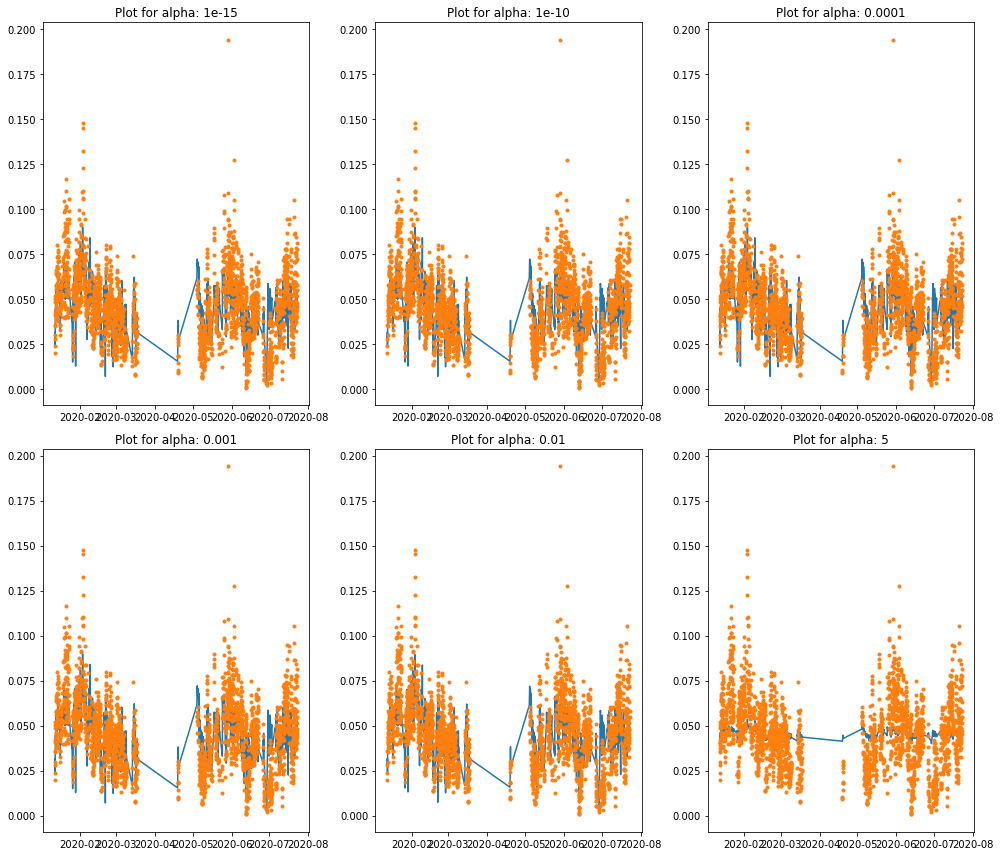

In [78]:
from sklearn.linear_model import Ridge
def MSridge_regression(data, predictors, alpha, models_to_plot={}):
    #Fit the model
    ridgereg = Ridge(alpha=alpha,normalize=True)
    ridgereg.fit(data[predictors],data['106VE04_Ni_soln'])
    y_pred = ridgereg.predict(data[predictors])
    
    rcParams['figure.figsize'] = 14, 12
    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(data.index,y_pred)
        plt.plot(data.index, data['106VE04_Ni_soln'],'.')
        plt.title('Plot for alpha: %.3g'%alpha)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['106TK01_Ni'])**2)
    ret = [rss]
    ret.extend([ridgereg.intercept_])
    ret.extend(ridgereg.coef_)
    return ret

#Initialize predictors to be set of 15 powers of x
#predictors=['x']
#predictors.extend(['x_%d'%i for i in range(2,16)])

#Set the different values of alpha to be tested
alpha_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

#Initialize the dataframe for storing coefficients.
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['alpha_%.2g'%alpha_ridge[i] for i in range(0,10)]
coef_matrix_ridge = pd.DataFrame(index=ind, columns=col)

models_to_plot = {1e-15:231, 1e-10:232, 1e-4:233, 1e-3:234, 1e-2:235, 5:236}
for i in range(10):
    MSridge_regression(df_MSdata_ridgeReady, predictors, alpha_ridge[i], models_to_plot)

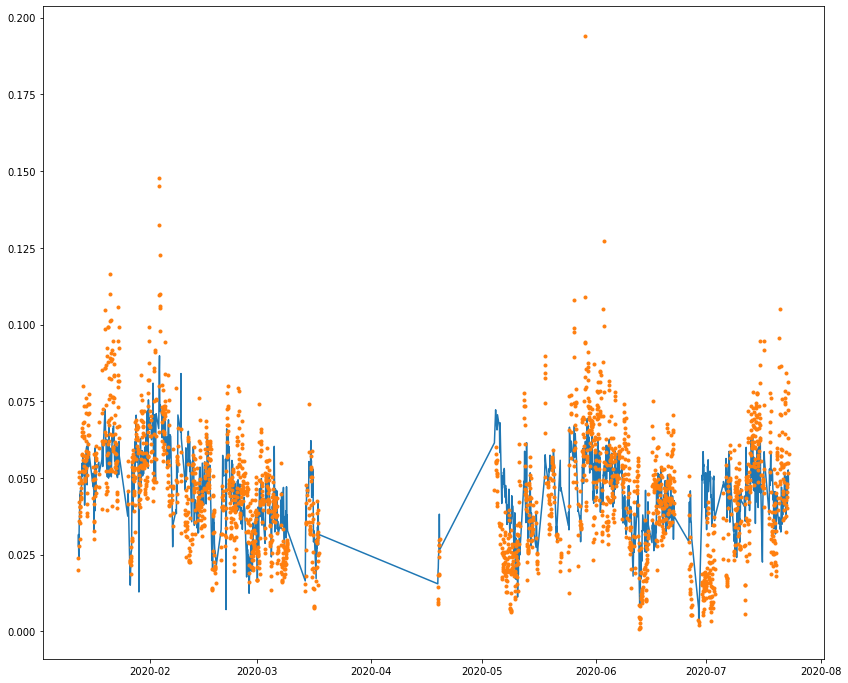

In [81]:
ridgereg = Ridge(alpha=.001,normalize=True)
ridgereg.fit(df_MSdata_ridgeReady[predictors],df_MSdata_ridgeReady['106VE04_Ni_soln'])
y_pred = ridgereg.predict(df_MSdata_ridgeReady[predictors])

#plt.subplot(models_to_plot[alpha])
plt.tight_layout()
plt.plot(df_MSdata_ridgeReady['106VE04_Ni_soln'].index, y_pred)
plt.plot(df_MSdata_ridgeReady['106VE04_Ni_soln'].index, df_MSdata_ridgeReady['106VE04_Ni_soln'],'.')
#plt.title('Plot for alpha: %.3g'%alpha)

In [84]:
reg_intercept = ridgereg.intercept_
reg_coef = ridgereg.coef_
print('reg_intercept:', reg_intercept)
print('reg_coef:', reg_coef)

reg_intercept: 0.167293627122493
reg_coef: [-1.13562602e-03  5.64586689e-05 -4.39535054e-03 -1.77104562e-05
 -1.72540353e-04 -5.66003668e-03  4.79078308e-02]


In [ ]:
predictors = ['106TK01_Fe', 'MS_Flow', 'MS_Feed_Temp', 'Rec_Gas', '106TK01_Mg',
       '106TK01_pH', '106TK01_Ni']

In [117]:
#imports
import numpy as np
import pandas as pd
import math

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline


#create our X and y
# replace train_df with df_MSdata_ridgeReady
# replace medv with '106VE04_Ni_soln'
#X = train_df.drop('medv', axis=1)
#y = train_df['medv']

X = df_MSdata_ridgeReady.drop('106VE04_Ni_soln', axis=1)
y = df_MSdata_ridgeReady['106VE04_Ni_soln']


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)


steps = [
    ('scalar', StandardScaler()),
    ('poly', PolynomialFeatures(degree=3)),
    ('model', Ridge(alpha=10, fit_intercept=True))
]

ridge_pipe = Pipeline(steps)
ridge_pipe.fit(X_train, y_train)

print('Training Score: {}'.format(ridge_pipe.score(X_train, y_train)))
print('Test Score: {}'.format(ridge_pipe.score(X_test, y_test)))

Training Score: 0.55560247016514
Test Score: 0.5243537835600299


In [125]:
ridge_pipe.coef_

AttributeError: 'Pipeline' object has no attribute 'coef_'

In [107]:
df_MSdata_ridgeReady.head()

,106TK01_Fe,MS_Flow,MS_Feed_Temp,Rec_Gas,106TK01_Mg,106TK01_pH,106TK01_Ni,106VE04_Ni_soln
DATETIME,,,,,,,,
2020-01-12 10:00:00,1.74,1.37e+03,73.5,1.59e+03,4.87,3.13,3.25,0.0238
2020-01-12 11:00:00,1.71,1.38e+03,73.2,1.59e+03,4.78,3.15,3.27,0.02
2020-01-12 12:00:00,1.68,1.41e+03,73.3,1.64e+03,4.68,3.18,3.2,0.0279
2020-01-12 13:00:00,1.65,1.43e+03,73.7,1.67e+03,4.59,3.2,3.12,0.0358
2020-01-12 14:00:00,1.64,1.47e+03,73.8,1.66e+03,4.58,3.19,3.2,0.0421


In [119]:
model.intercept_

NameError: name 'model' is not defined